# Feature Engineering

## Table of Contents

- Load Data
- Loan Related Features
    - checkpoint
- User Purchasing Behavior Features
    - checkpoint
- User Repayment Behavior Features
    - checkpoint
- Loan Quality
    - checkpoint
- RFM Analysis
    - Scores Definition
    - Segment Definition
    - checkpoint

In [4]:
from copy import deepcopy

import numpy as np
import pandas as pd

# visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [5]:
# plotly config
import plotly.io as pio
pio.renderers.default = "browser"

template = "plotly_white"
colors = {
    "red": "rgb(255,0,0)",
    "dark_blue": "rgb(30,144,255)",
    "medium_blue": "rgb(0,191,255)",
    "light_blue": "rgb(135,206,250)",
    "dark_purple": "rgb(202, 105, 157)",
    "medium_purple": "rgb(221, 136, 172)",
    "light_purple": "rgb(234, 169, 189)",
    "dark_gray": "rgb(169,169,169)",
    "medium_gray": "rgb(192,192,192)",
    "light_gray": "rgb(211,211,211)"
}
title_font_size = 22
font_size = 18

# Load Data

In [7]:
df_loans = pd.read_pickle("../data/processed/df_loans.pkl")
df_repayments = pd.read_pickle("../data/processed/df_repayments.pkl")
df_transactions = pd.read_pickle("../data/processed/df_transactions.pkl")

In [8]:
df_repayments = df_repayments.sort_values(by=["loan_id", "created_at"])

# Loan Related Features

- **loan term:** length of time over which a loan is to be repaid (days)
- **loan fees:** charges that have incurred when the loan was taken
- **loan amount:** loan principal amounts categorized as small (< R\\$ 3000), medium [R\\$ 3000, R\\$ 5000) and large ($\ge$ R\\$ 5000)
- **interest rate:**
    - raw loan interest rates
    - loan interest rates categorized as small (< 40%), medium [40%, 100%) and large ($\ge$ 100%)
- **default ratio:** number of defaulted repayments to total number of repayments
- **number of repayments**
- **avg repayment amount**
- **avg repayment lag**
- **due date exceeded**
- **max repayment delay:** time between loan due date and last repayment date
- **repaid amount percentage**
- **debt percentage**
- **ratio of manual repayment:** number of manual repayments (pix) to number of scheduled repayments (autopilot)

In [10]:
# Loan Term: length of time over which a loan is to be repaid (days)
df_loans["loan_term"] = (df_loans["due_date"] - df_loans["created_at"]).dt.days

In [11]:
# Loan Fees: charges that have incurred when the loan was taken
# difference between total_amount and (net) amount 
df_loans["loan_fees"] = (df_loans["total_amount"] - df_loans["amount"]).round()

In [12]:
# Loan Principal Amounts categories: small, medium, large
df_loans.loc[df_loans["amount"] < 3_000, "principal_amount_cat"] = "small"
df_loans.loc[df_loans["amount"].between(3_000, 5_000, inclusive="left"), "principal_amount_cat"] = "medium"
df_loans.loc[df_loans["amount"] >= 5_000, "principal_amount_cat"] = "large"

In [13]:
# Interest Rate: based on the formula A=P*(1+r*t) where
# P = Principal Amount
# R = Rate of interest
# t = Number of years
# A = Total accrued amount (both principal and the interest)
df_loans["interest_rate"] = (
    (df_loans["due_amount"] - df_loans["amount"] * 1) / (df_loans["amount"] * df_loans["loan_term"] / 365) * 100
).round()

# Interest Rate categories: small (< 40%), medium, large (>= 100%)
df_loans.loc[df_loans["interest_rate"] < 40, "interest_rate_cat"] = "small"
df_loans.loc[df_loans["interest_rate"].between(40, 100, inclusive="left"), "interest_rate_cat"] = "medium"
df_loans.loc[df_loans["interest_rate"] >= 100, "interest_rate_cat"] = "large"

In [14]:
df_temp = (
    pd.get_dummies(df_repayments['status_cleaned'])
    .rename(columns={"defaulted": "status_defaulted", "paid": "status_paid"})
)
df_repayments = pd.concat([df_repayments, df_temp], axis=1)
df_temp = (
    df_repayments
    .groupby(["loan_id"], as_index=False)
    .agg(
        count_defaulted=("status_defaulted", "sum"), 
        count_paid=("status_paid", "sum")
    )
).rename(columns={"loan_id": "id"})
df_loans = df_loans.merge(df_temp, how="left", on="id")

# Default Ratio: number of defaulted repayments to total number of repayments
df_loans["rate_default"] = df_loans["count_defaulted"] / (df_loans["count_defaulted"] + df_loans["count_paid"])

df_loans = df_loans.drop(columns=["count_defaulted", "count_paid"])
df_repayments = df_repayments.drop(columns=["status_defaulted", "status_paid"])

In [15]:
# Number of Repayments
df_temp = (
    df_repayments
    .groupby(["loan_id"], as_index=False)
    .agg(num_repayments=("id", "count"))
).rename(columns={"loan_id": "id"})
df_loans = df_loans.merge(df_temp, how="left", on="id")

In [16]:
# Average Repayment Amount
df_temp = (
    df_repayments
    .groupby(["loan_id"], as_index=False)
    .agg(avg_repayment_amount=("amount", "mean"))
).rename(columns={"loan_id": "id"})
df_loans = df_loans.merge(df_temp, how="left", on="id")
df_loans["avg_repayment_amount"] = df_loans["avg_repayment_amount"].round()

In [17]:
df_temp = (
    df_loans[["id", "created_at"]]
    .rename(columns={"id": "loan_id", "created_at": "loan_created_at"})
)
df_repayments = df_repayments.merge(df_temp, how="left", on="loan_id")

# Repayment Lag: difference between current repayment date and previous repayment date 
df_repayments["lag_repayment"] = df_repayments.groupby(["loan_id"], as_index=False)["created_at"].diff().dt.days
# first repayment date should be compared to the loan creation date
df_repayments.loc[df_repayments["lag_repayment"].isna(), "lag_repayment"] = (
    df_repayments[df_repayments["lag_repayment"].isna()]["created_at"] - \
    df_repayments[df_repayments["lag_repayment"].isna()]["loan_created_at"]
).dt.days

# Average Repayment Lag
df_temp = (
    df_repayments
    .groupby(["loan_id"], as_index=False)
    .agg(avg_lag_repayment=("lag_repayment", "mean"))
    .apply(np.ceil)
).rename(columns={"loan_id": "id"})
df_loans = df_loans.merge(df_temp, how="left", on="id")

df_repayments = df_repayments.drop(columns=["loan_created_at", "lag_repayment"])

In [18]:
df_temp = (
    df_loans[["id", "due_date"]]
    .rename(columns={"id": "loan_id"})
)
df_repayments = df_repayments.merge(df_temp, how="left", on="loan_id")

# Time Since Due Date: length of time between repayment and due date 
df_repayments["days_since_due_date"] = (df_repayments["created_at"] - df_repayments["due_date"]).dt.days
# in case the due date hasn't been exceeded the values will be negative
# default to 0 to represent that the due date hasn't been exceeded
df_repayments.loc[df_repayments["days_since_due_date"] < 0, "days_since_due_date"] = 0

# Due Date Exceeded
df_repayments["due_date_exceeded"] = 0
df_repayments.loc[df_repayments["days_since_due_date"] > 0, "due_date_exceeded"] = 1
df_temp = (
    df_repayments
    .groupby(["loan_id"], as_index=False)
    .agg(due_date_exceeded=("due_date_exceeded", "max"))
).rename(columns={"loan_id": "id"})
df_loans = df_loans.merge(df_temp, how="left", on="id")

# Max Repayment Delay: time between loan due date and last repayment date
df_temp = (
    df_repayments
    .groupby(["loan_id"], as_index=False)
    .agg(max_repayment_delay=("days_since_due_date", "max"))
).rename(columns={"loan_id": "id"})
df_loans = df_loans.merge(df_temp, how="left", on="id")

df_repayments = df_repayments.drop(columns=["due_date", "days_since_due_date", "due_date_exceeded"])

In [19]:
# auxiliary amount column to account for defaulted and refunded payments
df_repayments["payment"] = 0  # defaulted and refunded repayments should be excluded in sum
df_repayments.loc[df_repayments["status"] == "paid", "payment"] = df_repayments.loc[df_repayments["status"] == "paid", "amount"]

# Repaid Amount
df_temp = (
    df_repayments
    .groupby(["loan_id"], as_index=False)
    .agg(amount_repaid=("payment", "sum"))
).rename(columns={"loan_id": "id"})
df_loans = df_loans.merge(df_temp, how="left", on="id")

# Repaid Amount to Loan Amount Ratio
df_loans["pct_repaid"] = df_loans["amount_repaid"] / df_loans["total_amount"]
df_loans.loc[df_loans["pct_repaid"] > 1, "pct_repaid"] = 1
# Debt Ratio 
df_loans["pct_debt"] = 1 - df_loans["pct_repaid"]

df_loans = df_loans.drop(columns=["amount_repaid"])
df_repayments = df_repayments.drop(columns=["payment"])

C:\Users\lampr\AppData\Local\Temp\ipykernel_22756\185391014.py:3: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[  9.75  45.3   25.5  ... 126.74 203.37   0.53]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.



In [20]:
df_temp = (
    pd.get_dummies(df_repayments['type'])
    .rename(columns={"autopilot": "payment_autopilot", "pix": "payment_pix"})
)
df_repayments = pd.concat([df_repayments, df_temp], axis=1)

df_temp = (
    df_repayments
    .groupby(["loan_id"], as_index=False)
    .agg(
        count_payment_autopilot=("payment_autopilot", "sum"), 
        count_payment_pix=("payment_pix", "sum")
    )
).rename(columns={"loan_id": "id"})
df_loans = df_loans.merge(df_temp, how="left", on="id")

# Manual Repayments Rate: number of manual repayments (pix) to number of scheduled repayments (autopilot)
df_loans["rate_manual_repayments"] = (1 + df_loans["count_payment_pix"]) / (1 + df_loans["count_payment_autopilot"])

df_loans = df_loans.drop(columns=["count_payment_pix", "count_payment_autopilot"])
df_repayments = df_repayments.drop(columns=["payment_autopilot", "payment_pix"])

## ✅ checkpoint

In [22]:
df_loans.to_pickle("../data/processed/df_loans.pkl")

# User Purchasing Behavior Features

- **recency:** time since the user's last transaction
- **frequency:** how often users make a purchase
- **monetary:** total amount spent on purchases
- **avg number of installments**
- **average transaction lag:** average time between transactions per user
- **denied ratio:** number of denied transactions to total number of transactions
- **installments preference:** proportion of transactions with installments
- **credit preference:** number of credit transactions to number of debit transactions
- **online purchases preference:** number of online purchases to number of in-person purchases
- **card brand preference:** determine whether an International or Brazil-based card provider is prefered

In [24]:
# Recency: Time since the user's last transaction 
# Active users might be more financially active and potentially better candidates for loan repayment

# Frequency: How often user make a purchase
# Users who have a higher frequency of transactions might be more financially active 
# and potentially better candidates for loan repayment

# Monetary: Total amount spent on purchases
# Users who typically make larger transactions or have more consistent transaction amounts 
# might be more likely to repay loans

# to calculte Recency, the current date that will be used for comparison will be the max date of the sample
date_current = df_transactions["created_at"].max()

df_users = df_transactions.groupby("user_id", as_index=False).agg(
    {
        "created_at": lambda date : (date_current - date.max()).days,
        "id": lambda transaction : len(transaction),
        "amount": lambda amount : amount.sum(),
    }
).rename(columns={"created_at": "recency", "id": "frequency", "amount": "monetary"})

In [26]:
# Average Number of Installments
df_temp = (
    df_transactions
    .groupby(["user_id"], as_index=False)
    .agg(avg_intallments=("installments", "mean"))
)
df_users = df_users.merge(df_temp, how="left", on="user_id")

In [27]:
# Average Transaction Lag: average time between transactions per user
df_transactions["lag_transaction"] = df_transactions.groupby(["user_id"], as_index=False)["created_at"].diff().dt.days
df_temp = (
    df_transactions
    .groupby(["user_id"], as_index=False)
    .agg(avg_lag_transaction=("lag_transaction", "mean"))
)
df_users = df_users.merge(df_temp, how="left", on="user_id")
df_transactions = df_transactions.drop(columns=["lag_transaction"])

In [28]:
df_temp = (
    pd.get_dummies(df_transactions['status'])
    .rename(columns={"approved": "transaction_approved", "denied": "transaction_denied"})
)
df_transactions = pd.concat([df_transactions, df_temp], axis=1)

df_temp = (
    df_transactions
    .groupby(["user_id"], as_index=False)
    .agg(count_transaction_denied=("transaction_denied", "sum"))
)
df_users = df_users.merge(df_temp, how="left", on="user_id")

# Denied Ratio: number of denied transactions to total number of transactions 
df_users["rate_denied"] = df_users["count_transaction_denied"] / df_users["frequency"]

df_users = df_users.drop(columns=["count_transaction_denied"])
df_transactions = df_transactions.drop(columns=["transaction_approved", "transaction_denied"])

In [29]:
df_transactions.loc[df_transactions["installments"] == 1, "with_installment"] = False
df_transactions.loc[df_transactions["installments"] > 1, "with_installment"] = True

df_temp = (
    df_transactions
    .groupby(["user_id"], as_index=False)
    .agg(with_installment=("with_installment", "sum"))
)
df_users = df_users.merge(df_temp, how="left", on="user_id")

# Installments Preference: proportion of transactions with installments
df_users["preference_installment"] = df_users["with_installment"] / df_users["frequency"]

df_users = df_users.drop(columns=["with_installment"])
df_transactions = df_transactions.drop(columns=["with_installment"])

In [30]:
df_temp = (
    pd.get_dummies(df_transactions['payment_method'])
    .rename(columns={"credit": "payment_credit", "debit": "payment_debit"})
)
df_transactions = pd.concat([df_transactions, df_temp], axis=1)

df_temp = (
    df_transactions
    .groupby(["user_id"], as_index=False)
    .agg(
        count_payment_credit=("payment_credit", "sum"),
        count_payment_debit=("payment_debit", "sum"),
    )
)
df_users = df_users.merge(df_temp, how="left", on="user_id")

# Credit Preference: number of credit transactions to number of debit transactions 
df_users["preference_credit"] = (1 + df_users["count_payment_credit"]) / (1 + df_users["count_payment_debit"])  # smoothing

df_users = df_users.drop(columns=["count_payment_credit", "count_payment_debit"])
df_transactions = df_transactions.drop(columns=["payment_credit", "payment_debit"])

In [31]:
# Based on the capture method, derive whether a purchase was made in-person or online
purchase_in_person, purchase_online = ["emv", "contactless", "mpos"], ["payment_link", "ecommerce", "payment_link_web"]
df_transactions.loc[df_transactions["capture_method"].isin(purchase_in_person), "purchase_type"] = "in_person"
df_transactions.loc[df_transactions["capture_method"].isin(purchase_online), "purchase_type"] = "online"

df_temp = (
    pd.get_dummies(df_transactions['purchase_type'])
    .rename(columns={"in_person": "purchase_in_person", "online": "purchase_online"})
)
df_transactions = pd.concat([df_transactions, df_temp], axis=1)

df_temp = (
    df_transactions
    .groupby(["user_id"], as_index=False)
    .agg(
        count_purchase_in_person=("purchase_in_person", "sum"),
        count_purchase_online=("purchase_online", "sum"),
    )
)
df_users = df_users.merge(df_temp, how="left", on="user_id")

# Online Purchases Preference: number of online purchases to number of in-person purchases
df_users["preference_purchase_online"] = df_users["count_purchase_online"] / (1 + df_users["count_purchase_in_person"])  # smoothing

df_users = df_users.drop(columns=["count_purchase_in_person", "count_purchase_online"])
df_transactions = df_transactions.drop(columns=["purchase_type", "purchase_in_person", "purchase_online"])

In [32]:
# Based on the card brand, derive whether an International or Brazil-based card provider is being used
card_internation, card_brazil = ["mastercard", "visa", "amex"], ["elo", "hipercard"]
df_transactions.loc[df_transactions["card_brand"].isin(card_internation), "card_type"] = "card_international"
df_transactions.loc[df_transactions["card_brand"].isin(card_brazil), "card_type"] = "card_brazil"

df_temp = pd.get_dummies(df_transactions['card_type'])
df_transactions = pd.concat([df_transactions, df_temp], axis=1)

df_temp = (
    df_transactions
    .groupby(["user_id"], as_index=False)
    .agg(
        count_purchase_card_international=("card_international", "sum"),
        count_purchase_card_brazil=("card_brazil", "sum"),
    )
)
df_users = df_users.merge(df_temp, how="left", on="user_id")

# Card Brand Preference: determine whether an International or Brazil-based card provider is prefered
df_users["preference_card_brazil"] = df_users["count_purchase_card_brazil"] / (1 + df_users["count_purchase_card_international"])  # smoothing

df_users = df_users.drop(columns=["count_purchase_card_brazil", "count_purchase_card_international"])
df_transactions = df_transactions.drop(columns=["card_type", "card_international", "card_brazil"])

## ✅ checkpoint

In [34]:
df_users.to_pickle("../data/processed/df_user_purchasing_behavior.pkl")

# User Repayment Behavior Features

**Note:** The repayment behavior of the user is calculated at every point in time, meaning that the following features are cumulative. 

**Warning (Cold Start Problem):** When a user takes out a loan for the first time, there is no prior repayment history available. Thus, during modeling the features need to be shifted by one one point in time.

- **number of loans**
- **percentage of small loans:** principal amount < R\\$ 3000
- **percentage of medium loans:** principal amount [R\\$ 3000, R\\$ 5000)
- **percentage of large loans:** principal amount $\ge$ R\\$ 5000
- **percentage of loans with small interest rate:** interest rate < 40%
- **percentage of loans with medium interest rate:** interest rate [40%, 100%)
- **percentage of loans with large interest rate:** interest rate $\ge$ 100%
- **unpaid loans ratio:** number of unpaid loans to total number of loans
- **avg percentage of debt:** average percentage of debt incurred 
- **avg number of repayments**
- **avg repayment amount**
- **avg repayment lag**
- **avg default ratio**
- **due date exceeded rate:** number of loans who were repayed outside of term to the total number of loans
- **avg max repayment delay**
- **average manual repayments rate:** measures the preference of manual repayments (pix) over scheduled repayments (autopilot)

In [36]:
df_repayment_history = deepcopy(df_loans)
df_repayment_history = df_repayment_history.sort_values(by=["user_id", "created_at"])

columns_to_keep = ["id", "user_id", "created_at"]

In [37]:
# Number of Loans
df_repayment_history["user_num_loans"] = df_repayment_history.groupby(["user_id"], as_index=False).cumcount() + 1

columns_to_keep.append("user_num_loans")

In [38]:
df_temp = (
    pd.get_dummies(df_repayment_history['principal_amount_cat'], dtype=int)
    .rename(columns={"small": "loan_small", "medium": "loan_medium", "large": "loan_large"})
)
df_repayment_history = pd.concat([df_repayment_history, df_temp], axis=1)

# Percentage of Loans with Small, Medium and Large Principal Amounts
df_repayment_history["user_pct_loans_small"] = (
    df_repayment_history.groupby(["user_id"], as_index=False)["loan_small"].cumsum() / \
    (df_repayment_history.groupby(["user_id"], as_index=False).cumcount() + 1)
).round(2)
df_repayment_history["user_pct_loans_medium"] = (
    df_repayment_history.groupby(["user_id"], as_index=False)["loan_medium"].cumsum() / \
    (df_repayment_history.groupby(["user_id"], as_index=False).cumcount() + 1)
).round(2)
df_repayment_history["user_pct_loans_large"] = (
    df_repayment_history.groupby(["user_id"], as_index=False)["loan_large"].cumsum() / \
    (df_repayment_history.groupby(["user_id"], as_index=False).cumcount() + 1)
).round(2)

columns_to_keep.extend(["user_pct_loans_small", "user_pct_loans_medium", "user_pct_loans_large"])

In [39]:
df_temp = (
    pd.get_dummies(df_repayment_history['interest_rate_cat'], dtype=int)
    .rename(columns={"small": "interest_rate_small", "medium": "interest_rate_medium", "large": "interest_rate_large"})
)
df_repayment_history = pd.concat([df_repayment_history, df_temp], axis=1)

# Percentage of Loans with Small, Medium and Large Interest Rates
df_repayment_history["user_pct_int_rate_small"] = (
    df_repayment_history.groupby(["user_id"], as_index=False)["interest_rate_small"].cumsum() / \
    (df_repayment_history.groupby(["user_id"], as_index=False).cumcount() + 1)
).round(2)
df_repayment_history["user_pct_int_rate_medium"] = (
    df_repayment_history.groupby(["user_id"], as_index=False)["interest_rate_medium"].cumsum() / \
    (df_repayment_history.groupby(["user_id"], as_index=False).cumcount() + 1)
).round(2)
df_repayment_history["user_pct_int_rate_large"] = (
    df_repayment_history.groupby(["user_id"], as_index=False)["interest_rate_large"].cumsum() / \
    (df_repayment_history.groupby(["user_id"], as_index=False).cumcount() + 1)
).round(2)

columns_to_keep.extend(["user_pct_int_rate_small", "user_pct_int_rate_medium", "user_pct_int_rate_large"])

In [40]:
df_repayment_history["loan_unpaid"] = 0
df_repayment_history.loc[df_repayment_history["pct_repaid"] < 1, "loan_unpaid"] = 1 

# Unpaid Loans Ratio: number of unpaid loans to total number of loans
df_repayment_history["user_ratio_unpaid_loans"] = (
    df_repayment_history.groupby(["user_id"], as_index=False)["loan_unpaid"].cumsum() / \
    (df_repayment_history.groupby(["user_id"], as_index=False).cumcount() + 1)
).round(2)

columns_to_keep.append("user_ratio_unpaid_loans")

In [41]:
# Average Percentage of Debt: average percentage of debt incurred
df_repayment_history["user_avg_pct_debt"] = (
    df_repayment_history.groupby(["user_id"], as_index=False)["pct_debt"].cumsum() / \
    (df_repayment_history.groupby(["user_id"], as_index=False).cumcount() + 1)
).round(2)

columns_to_keep.append("user_avg_pct_debt")

In [42]:
# Average Number of Repayments
df_repayment_history["user_avg_num_repayments"] = (
    df_repayment_history.groupby(["user_id"], as_index=False)["num_repayments"].cumsum() / \
    (df_repayment_history.groupby(["user_id"], as_index=False).cumcount() + 1)
).apply(np.ceil)

columns_to_keep.append("user_avg_num_repayments")

In [43]:
# Average Repayment Amount
df_repayment_history["user_avg_repayment_amount"] = (
    df_repayment_history.groupby(["user_id"], as_index=False)["avg_repayment_amount"].cumsum() / \
    (df_repayment_history.groupby(["user_id"], as_index=False).cumcount() + 1)
)

columns_to_keep.append("user_avg_repayment_amount")

In [44]:
# Average Repayment Lag
df_repayment_history["user_avg_lag_repayment"] = (
    df_repayment_history.groupby(["user_id"], as_index=False)["avg_lag_repayment"].cumsum() / \
    (df_repayment_history.groupby(["user_id"], as_index=False).cumcount() + 1)
).apply(np.ceil)

columns_to_keep.append("user_avg_lag_repayment")

In [45]:
# Average Default Rate
df_repayment_history["user_avg_rate_default"] = (
    df_repayment_history.groupby(["user_id"], as_index=False)["rate_default"].cumsum() / \
    (df_repayment_history.groupby(["user_id"], as_index=False).cumcount() + 1)
)

columns_to_keep.append("user_avg_rate_default")

In [46]:
# Due Date Exceeded Rate: number of loans who were repayed outside of term to the total number of loans
df_repayment_history["user_rate_due_date_exceeded"] = (
    df_repayment_history.groupby(["user_id"], as_index=False)["due_date_exceeded"].cumsum() / \
    (df_repayment_history.groupby(["user_id"], as_index=False).cumcount() + 1)
)

columns_to_keep.append("user_rate_due_date_exceeded")

In [47]:
# Average Maximum Repayment Delay
df_repayment_history["user_avg_max_repayment_delay"] = (
    df_repayment_history.groupby(["user_id"], as_index=False)["max_repayment_delay"].cumsum() / \
    (df_repayment_history.groupby(["user_id"], as_index=False).cumcount() + 1)
).apply(np.ceil)

columns_to_keep.append("user_avg_max_repayment_delay")

In [48]:
# Average Manual Repayments Rate: measures the preference of manual repayments (pix) over scheduled repayments (autopilot)
df_repayment_history["user_avg_rate_manual_repayments"] = (
    df_repayment_history.groupby(["user_id"], as_index=False)["rate_manual_repayments"].cumsum() / \
    (df_repayment_history.groupby(["user_id"], as_index=False).cumcount() + 1)
)

columns_to_keep.append("user_avg_rate_manual_repayments")

In [49]:
# clean-up
df_repayment_history = df_repayment_history.loc[:, df_repayment_history.columns.isin(columns_to_keep)]

## ✅ checkpoint

In [51]:
df_repayment_history.to_pickle("../data/processed/df_user_repayment_history.pkl")

# Loan Quality

**Definition:**
- We define the quality of a loan based on its final status (paid, debt) and its repayment history, specifically the default rate.
- **Loans in Debt**
    - Loans resulting in debt are of low quality.
- **Paid Loans**
    - The quality of a paid loan is assessed based on the default rate of that loan benchmarked to the upper fence default rate across all paid loans.
    - However, loans vary in amount, a factor that impacts the profile of the loan and the user repayment behavior.
    - Thus, to define the quality of a paid loan we need to benchmark the default rate of a paid loan to the upper fence default rate of the category that it belongs to. The category is defined based on the principal amount (small, medium, large).

In [53]:
df_loans_debt = df_loans[df_loans["status_cleaned"] == "debt"]
df_loans_repaid = df_loans[df_loans["status_cleaned"] == "repaid"]

# Loans resulting in debt are of low quality
df_loans_debt["loan_quality"] = "low_quality"

C:\Users\lampr\AppData\Local\Temp\ipykernel_22756\3012232027.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [54]:
# calculate the 5-number summary for default rate per loan principal amount category
stats = df_loans_repaid[df_loans_repaid["status_cleaned"] == "repaid"].groupby(["principal_amount_cat"], as_index=False)["rate_default"].describe()
# calculate the upper fence (Q3 + 1.5*IQR) to find the outliers
stats["upper_fence"] = stats["75%"] + 1.5 * (stats["75%"] - stats["25%"])

stats

,principal_amount_cat,count,mean,std,min,25%,50%,75%,max,upper_fence
0,large,4470.0,0.053071,0.084829,0.0,0.0,0.027778,0.067514,0.800000,0.168785
1,medium,271.0,0.071481,0.118876,0.0,0.0,0.036364,0.081633,0.769231,0.204082
2,small,306.0,0.091619,0.128716,0.0,0.0,0.035423,0.142857,0.882353,0.357143


In [55]:
stats = stats[["principal_amount_cat", "upper_fence"]]
df_loans_repaid = df_loans_repaid.merge(stats, how="left", on=["principal_amount_cat"])

# loans that have a default rate higher than the upper fence (outliers) are of low quality, otherwise of high quality
# the upper fence is respective to the principal amount category
df_loans_repaid["loan_quality"] = "high_quality"
df_loans_repaid.loc[df_loans_repaid["rate_default"] > df_loans_repaid["upper_fence"], "loan_quality"] = "low_quality"

df_loans_repaid = df_loans_repaid.drop(columns=["upper_fence"])

In [56]:
df_loans = pd.concat([df_loans_debt, df_loans_repaid])

In [57]:
df_loans["loan_quality"].value_counts()

loan_quality
high_quality    4682
low_quality     1906
Name: count, dtype: int64

## ✅ checkpoint

In [59]:
df_loans.to_pickle("../data/processed/df_loans.pkl")

# RFM Analysis

- Customer (User) Segmentation based on RFM Analysis
- RFM segments the consumer (user) base by their purchasing patterns or habits based on Recency (R), Frequency (F) and Monetary Value (M)
- *Recency:* how long ago they made a purchase
- *Frequency:* how often they make purchases
- *Monetary Value:* how much money they spend

## Scores Definitions

Typically, RFM scores are in a scale of 1-5. 

However, the scores will range from 1-3 (the lower, the better the results for a customer) in order to avoid segments that have similar loan repayment behavior.

| Recency | Frequency | Monetary |
| :-----: | :-------: | :------: |
| up to 1 month (1) | more than 500 (1) | more than R\\$ 500k (1) |
| 1 to 3 months (2) | 100 to 500 (2) | R\\$ 100k to 500k (2) |
| more than 3 months (3) | less than 100 (3) | less than R\\$100k (3) |

In [62]:
df_users[["recency", "frequency", "monetary"]].describe()

,recency,frequency,monetary
count,3043.000000,3043.000000,3.043000e+03
mean,125.346369,473.829445,6.592698e+05
std,91.242729,1047.322255,1.951745e+07
min,0.000000,1.000000,4.150000e+01
25%,42.000000,74.000000,5.357745e+04
50%,105.000000,179.000000,1.032773e+05
75%,196.000000,463.000000,1.984965e+05
max,358.000000,25660.000000,1.000132e+09


In [63]:
# Recency buckets
# Higher values indicate users who haven't made a purchase for a long time (not active)

df_users.loc[df_users["recency"] <= 30, "recency_bin"] = "1"
df_users.loc[df_users["recency"].between(30, 90, inclusive="right"), "recency_bin"] = "2"
df_users.loc[df_users["recency"] > 90, "recency_bin"] = "3"

In [64]:
# Frequency buckets
# Higher values indicate users who make frequent purchases (more active)

df_users.loc[df_users["frequency"] <= 100, "frequency_bin"] = "3"
df_users.loc[df_users["frequency"].between(100, 500, inclusive="right"), "frequency_bin"] = "2"
df_users.loc[df_users["frequency"] > 500, "frequency_bin"] = "1"

In [65]:
# Monetary buckets
# Higher values indicate users with higher spendings

df_users.loc[df_users["monetary"] <= 100_000, "monetary_bin"] = "3"
df_users.loc[df_users["monetary"].between(100_000, 500_000, inclusive="right"), "monetary_bin"] = "2"
df_users.loc[df_users["monetary"] > 500_000, "monetary_bin"] = "1"

## Segment Definitions

Customer (user) segments identified:
- **Champions:** Extremely active cutomers (high frequency and low recency) with moderate to high monetary value
- **Big Spenders:** Active customers (medium recency and frequency) with high monetary value
- **Promising:** Active customers (medium recency and frequency) with low to moderate monetary value
- **Recent:** Customers who entered our base recently (low frequency and moderate to high recency) with low to moderate monetary value
- **Inactive:** Customers with extremely low activity (low recency and low to moderate frequency); monetary value isn't a factor here

In [67]:
df_users["rfm_segment"] = df_users["recency_bin"] + df_users["frequency_bin"] + df_users["monetary_bin"]

In [68]:
# define customer clusters based on RFM Analysis
cluster_1 = ["111", "113", "112"]  # Champions
cluster_2 = ["121", "231", "221", "211"]  # Big Spenders
cluster_3 = ["213", "122", "123", "212", "222", "223", "311", "313", "312"]  # Promising Customers
cluster_4 = ["131", "132", "133", "232", "233"]  # Recent Customers
cluster_5 = ["331", "332", "333", "321", "322", "323"]  # Inactive Customers

clusters = list(
    zip(
        [cluster_1, cluster_2, cluster_3, cluster_4, cluster_5],
        ["Champions", "Big Spenders", "Promising", "Recent", "Inactive"]
    )
)

for cluster, label in clusters:
    df_users.loc[df_users["rfm_segment"].isin(cluster), "rfm_segment_desc"] = label

In [69]:
fig = px.histogram(
    df_users,
    x="rfm_segment_desc",
    histnorm="percent",
    color_discrete_sequence=[colors["dark_blue"]],
)

fig.update_layout(
    title="<b>83% of the users have moderate to modest activity and spending habits<br><sub>Promising and Inactive segments</sub></b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="user segment",
    yaxis_title="% of user",
    template=template,
)
fig.update_xaxes(
    categoryorder='array', 
    categoryarray=[label for cluster, label in clusters]
)
fig.update_traces(
    texttemplate="%{y:,.0f}%",
    textposition="inside"
)

fig.show()

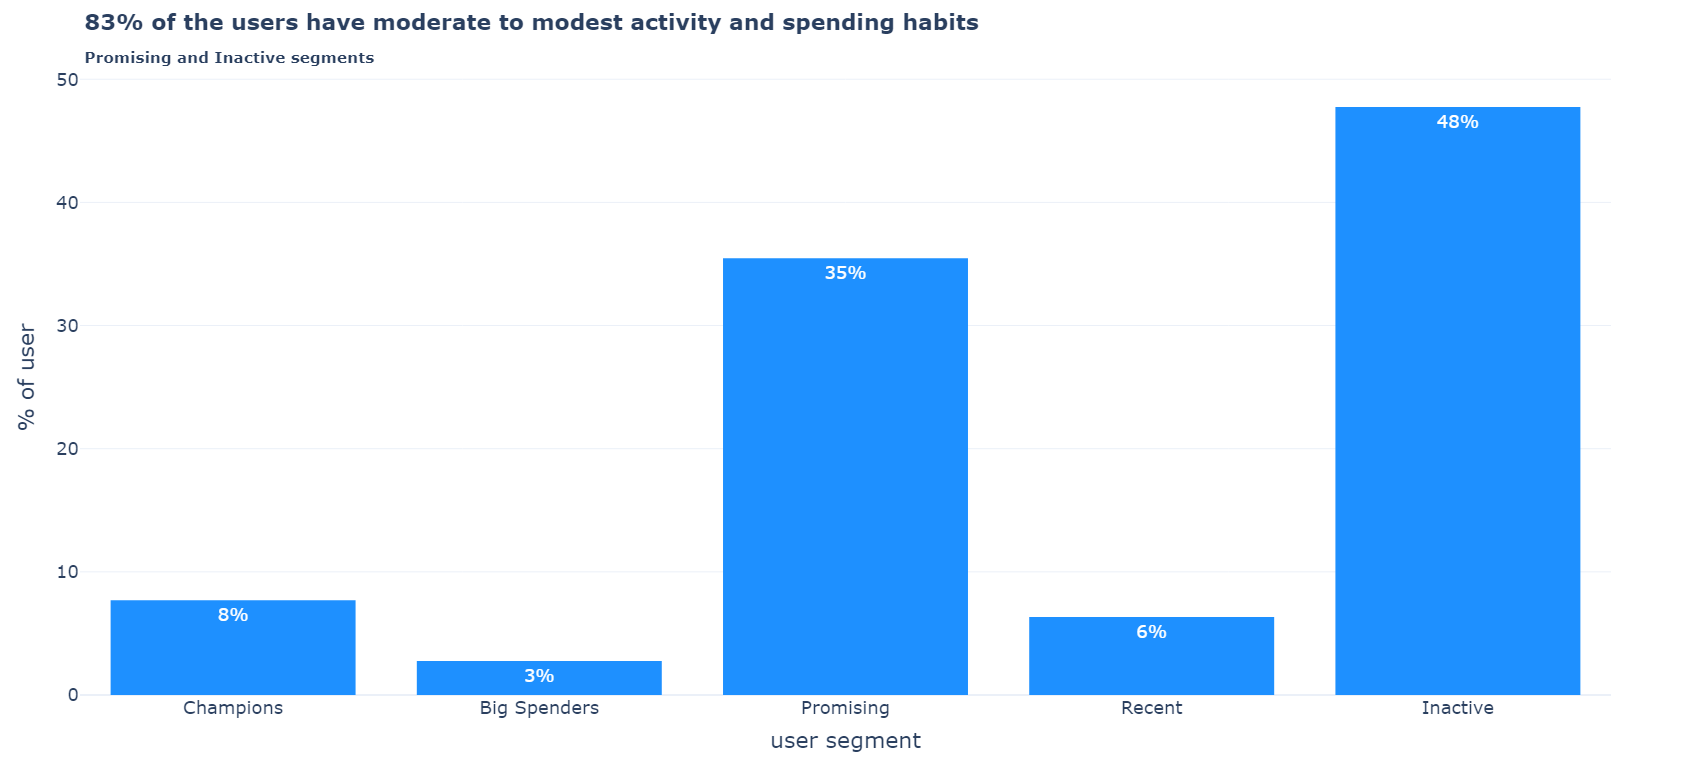

In [71]:
fig = px.box(
    df_users, 
    x="rfm_segment_desc", 
    y="recency",
    color_discrete_sequence=[colors["dark_blue"]]
)

fig.update_layout(
    title="<b>Recency distribution per user segment</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="user segment",
    yaxis_title="Recency (days)",
    showlegend=False,
    template=template,
)
fig.update_xaxes(
    categoryorder='array', 
    categoryarray=[label for cluster, label in clusters]
)

fig.show()

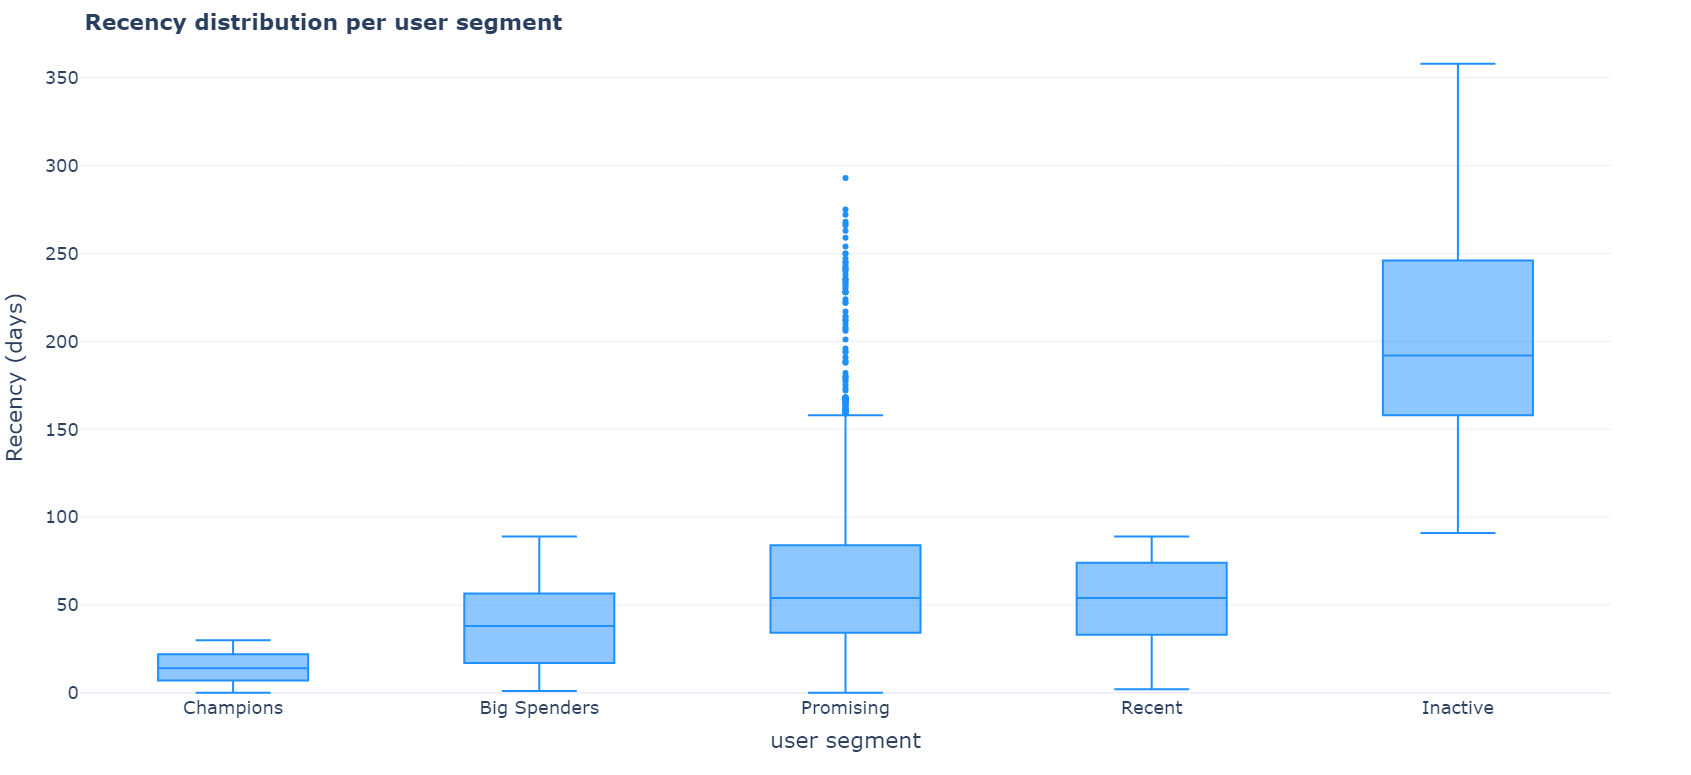

In [73]:
df_users.groupby(["rfm_segment_desc"], as_index=False)["recency"].describe()

,rfm_segment_desc,count,mean,std,min,25%,50%,75%,max
0,Big Spenders,84.0,38.654762,25.220710,1.0,17.0,38.0,56.25,89.0
1,Champions,234.0,15.209402,8.483951,0.0,7.0,14.0,22.00,30.0
2,Inactive,1453.0,200.197522,64.069835,91.0,158.0,192.0,246.00,358.0
3,Promising,1079.0,68.266914,52.968671,0.0,34.5,54.0,84.00,293.0
4,Recent,193.0,52.207254,24.212569,2.0,33.0,54.0,74.00,89.0


In [74]:
fig = px.box(
    df_users, 
    x="rfm_segment_desc", 
    y="frequency",
    color_discrete_sequence=[colors["dark_blue"]]
)

fig.update_layout(
    title="<b>Frequency distribution per user segment</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="user segment",
    yaxis_title="Frequency<br>(number of purchases)",
    showlegend=False,
    template=template,
)
fig.update_xaxes(
    categoryorder='array', 
    categoryarray=[label for cluster, label in clusters]
)

fig.show()

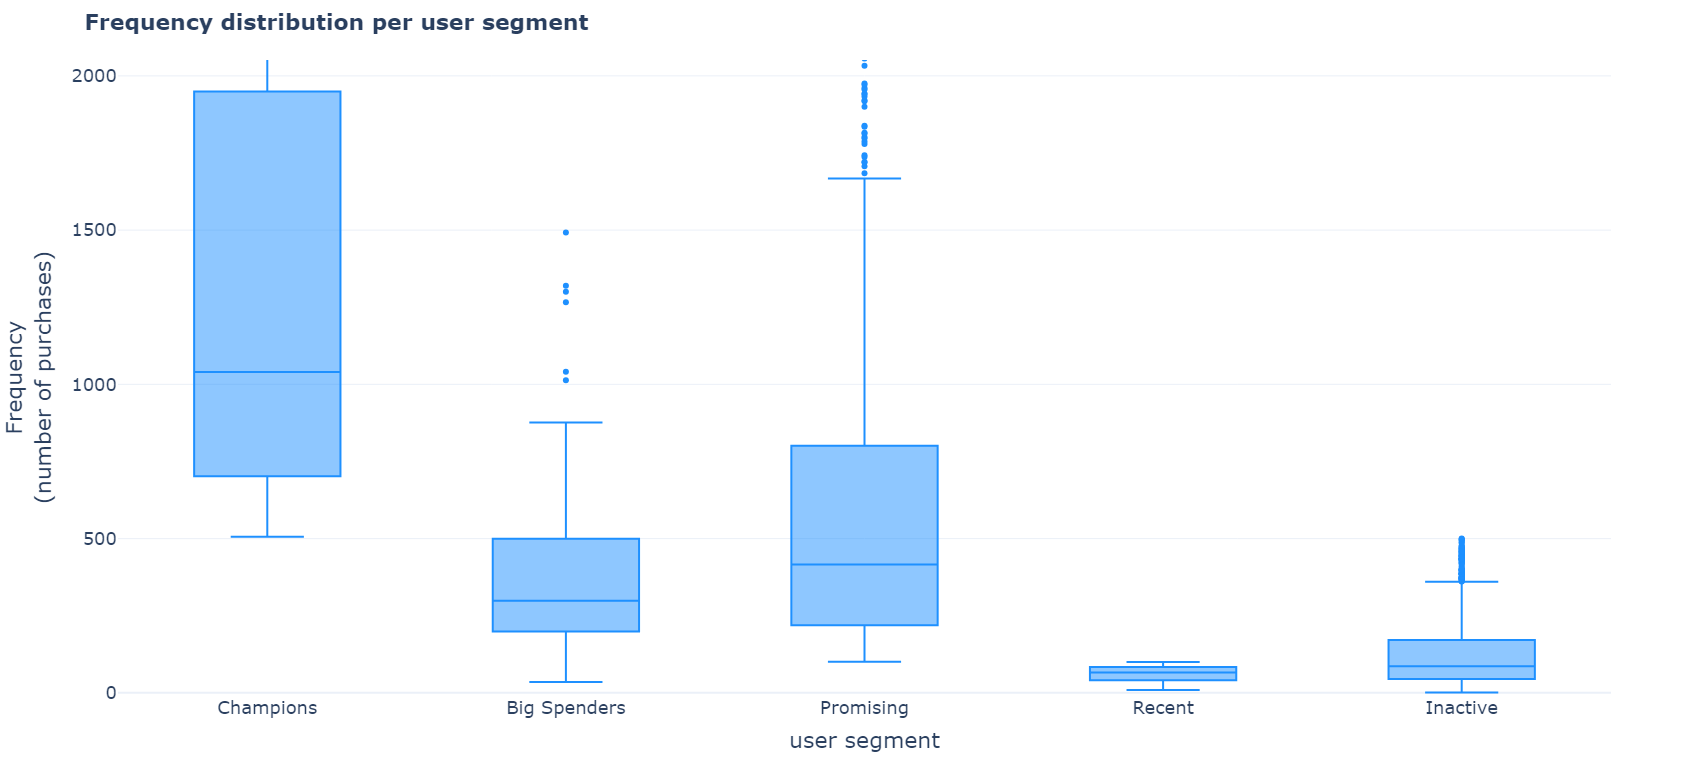

In [76]:
df_users.groupby(["rfm_segment_desc"], as_index=False)["frequency"].describe()

,rfm_segment_desc,count,mean,std,min,25%,50%,75%,max
0,Big Spenders,84.0,665.071429,1467.146109,35.0,198.75,298.5,498.25,10713.0
1,Champions,234.0,1761.388889,1903.618172,506.0,704.75,1040.0,1922.75,15517.0
2,Inactive,1453.0,124.800413,110.861813,1.0,45.00,86.0,171.00,500.0
3,Promising,1079.0,723.357739,1228.848701,101.0,219.00,416.0,800.00,25660.0
4,Recent,193.0,62.145078,25.583598,9.0,41.00,66.0,84.00,100.0


In [77]:
fig = px.box(
    df_users, 
    x="rfm_segment_desc", 
    y="monetary",
    color_discrete_sequence=[colors["dark_blue"]]
)

fig.update_layout(
    title="<b>Monetary amount distribution per user segment</b>",
    title_font_size=title_font_size,
    font_size=font_size,
    xaxis_title="user segment",
    yaxis_title="Monetary amount (R$)",
    showlegend=False,
    template=template,
)
fig.update_xaxes(
    categoryorder='array', 
    categoryarray=[label for cluster, label in clusters]
)

fig.show()

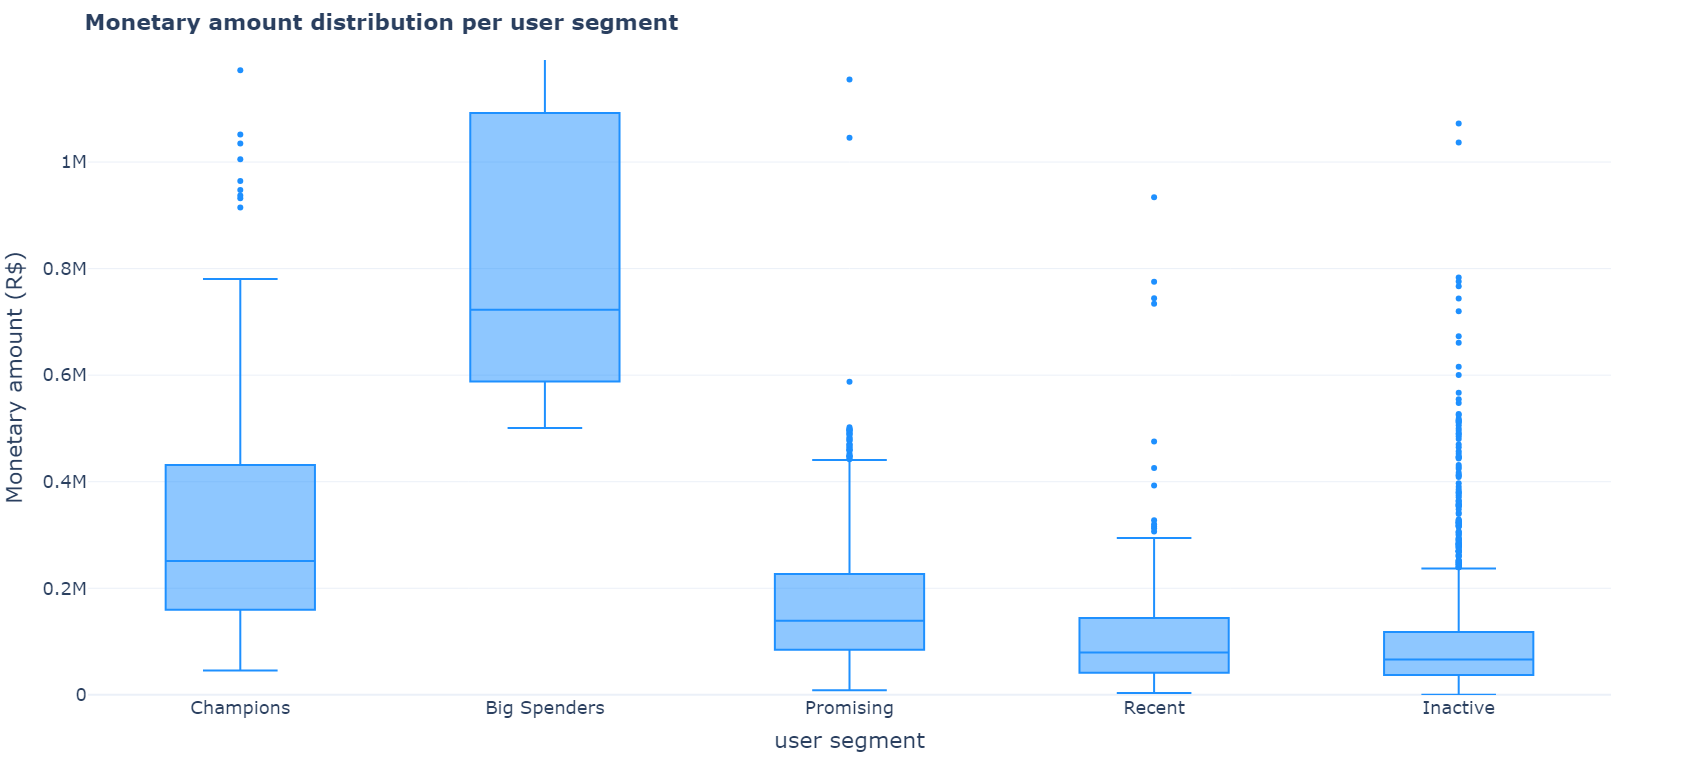

In [79]:
df_users.groupby(["rfm_segment_desc"], as_index=False)["monetary"].describe()

,rfm_segment_desc,count,mean,std,min,25%,50%,75%,max
0,Big Spenders,84.0,1.788642e+07,1.167952e+08,500928.83,588990.5825,722995.250,1083493.380,1.000132e+09
1,Champions,234.0,3.575111e+05,3.672372e+05,45570.97,159925.9800,251296.575,430517.105,3.313743e+06
2,Inactive,1453.0,1.267138e+05,5.941056e+05,41.50,37095.3000,66212.000,117817.980,2.046910e+07
3,Promising,1079.0,1.973428e+05,5.962927e+05,8776.76,84446.8800,139180.370,226928.645,1.406241e+07
4,Recent,193.0,1.191376e+05,1.315886e+05,3508.37,41413.0400,79474.430,143526.500,9.340907e+05


## ✅ checkpoint

In [81]:
df_users = df_users.drop(columns=['recency_bin', 'frequency_bin', 'monetary_bin', 'rfm_segment'])

df_users.to_pickle("../data/processed/df_user_purchasing_behavior.pkl")